In [1]:
import matplotlib.pyplot as plt
from sparta_tools import moria, sparta
import plotly.graph_objects as go
import pickle as pkl
import h5py as hp
import os
import copy
import numpy as np
import sys
import post_props as pp

BASE = '/Users/cosinga/code/'
SIMPATH = '/Users/cosinga/sims/sparta_output/'

sys.path.append(BASE + 'tree_tracks')
from tree_tracks.tracker import Trajectory
from tree_tracks.visual import Image
from tree_tracks.storage import Tree, Vines, Simulation


In [2]:
SIMNAME = 'L0063_N0256_CBol'
SPARTA_FILE = '/sparta_no_cuts.hdf5'
SAVEPATH = '/Users/cosinga/code/splots/animations/'
tree_filename = '%s_tree.pkl'%SIMNAME
link_filename = '%s_linked_tcr_data.pkl'%SIMNAME
vines_filename = '%s_vines.pkl'%SIMNAME
link_data_exists = os.path.exists(SAVEPATH + link_filename)
vines_exists = os.path.exists(SAVEPATH + vines_filename)
tree_exists = os.path.exists(SAVEPATH + tree_filename)

if not link_data_exists or not vines_exists or not tree_exists:
    if not link_data_exists or not vines_exists:
        sdata = sparta.load(SIMPATH + '%s/'%SIMNAME, load_halo_data = True, 
                    anl_match = ['hps', 'rsp'], anl_pad_unmatched = True,
                    res_match = ['ifl', 'oct', 'tjy'], res_pad_unmatched = True)
   
    if not link_data_exists:
        data = pp.link_tracer_halo_data(sdata['tcr_sho'], sdata['halos'], sdata['simulation'])
        pkl.dump(data, open(link_filename, 'wb'), pkl.HIGHEST_PROTOCOL)
    # if not vines_exists:
    #     simdata = sdata['simulation']
    #     sim = Simulation(simdata['box_size'], simdata['snap_t'], ['snap_t', 'snap_z'], simdata)
    #     sdict = pp.reformat_sparta(sdata, sim.getSnaps())
    #     vines = Vines(sdict, sdata['halos'], sim)
    #     pkl.dump(vines, open(vines_filename, 'wb'), pkl.HIGHEST_PROTOCOL)
    if not tree_exists:
        massdefs = ['M200m_all_spa', 'Morb-all_all_spa', 'Morb-all_orb_spa', 'Mvir_all_spa', 'Mpeak']
        pids = ['parent_id_cat', 'parent_id_orbinf']
        others = ['mask_alive', 'mask_cut', 'id', 'x', 'R200m_all_spa']

        mdata = moria.load(SIMPATH + '%s/moria_trees/moria_tree_orb_defs.hdf5'%SIMNAME, massdefs + pids + others)
        mconfig = moria.loadConfig(SIMPATH + '%s/moria_trees/moria_tree_orb_defs.hdf5'%SIMNAME)
        simdata = mconfig['simulation']
        sim = Simulation(simdata['box_size'], simdata['snap_t'], ['snap_t', 'snap_z'], simdata)
        tree = Tree(mdata, sim)
        pkl.dump(tree, open(tree_filename, 'wb'), pkl.HIGHEST_PROTOCOL)


else:
    data = pkl.load(open(link_filename, 'rb'))
    vines = pkl.load(open(vines_filename, 'rb'))
    tree = pkl.load(open(tree_filename, 'rb'))


sparta.load: Loading file /Users/cosinga/sims/sparta_output/L0063_N0256_CBol/sparta_orb_defs.hdf5.
sparta.load: Loading 19226/19226 halos from SPARTA file (entire array)...
sparta.load: Matching result IDs in tracer sho, halo 1923/19226
sparta.load: Matching result IDs in tracer sho, halo 3845/19226
sparta.load: Matching result IDs in tracer sho, halo 5767/19226
sparta.load: Matching result IDs in tracer sho, halo 7689/19226
sparta.load: Matching result IDs in tracer sho, halo 9611/19226
sparta.load: Matching result IDs in tracer sho, halo 11533/19226
sparta.load: Matching result IDs in tracer sho, halo 13455/19226
sparta.load: Matching result IDs in tracer sho, halo 15377/19226
sparta.load: Matching result IDs in tracer sho, halo 17299/19226
sparta.load: Matching result IDs in tracer sho, halo 19221/19226


In [3]:
data = pkl.load(open(link_filename, 'rb'))

print(data.keys())
for k, v in data.items():
    if isinstance(v, dict):
        print(k, v.keys())
    if isinstance(v, np.ndarray):
        print(k, v.dtype.names)

dict_keys(['res_ifl', 'res_oct', 'res_tjy', 'hosts', 'tcr_halos', 'sim'])
res_ifl ('born_in_halo', 'sub_mass_ratio', 't_infall', 'tracer_id', 'vrv200', 'vtv200', 'x')
res_oct ('last_pericenter_snap', 'n_is_lower_limit', 'n_pericenter', 'tracer_id')
res_tjy ('first_snap', 'last_snap', 'r', 'tracer_id', 'v', 'vr', 'vt', 'x')
hosts dict_keys(['R200m', 'M200m', 'id', 'sparta_idx'])
tcr_halos dict_keys(['R200m', 'M200m', 'sparta_idx'])
sim dict_keys(['snap_z'])


# Escaping Subhalos
here we are looking at subhalos that have a pericenter but then escape. If we can determine a priori whether or not a subhalo will escape, we can skip their host-sub assignments.

In [4]:
mask = pp.get_esc_subhalos_mask(data)
print(mask.shape, mask.sum())



(28050,) 1158


In [9]:

esc_tjy = data['res_tjy'][mask]
tcr_idxs = np.arange(len(mask))[mask]


fig = go.Figure()
for i in range(20):
    r = esc_tjy['r'][i]
    hostr = data['hosts']['R200m'][mask][i]
    alive = r > 0
    
    rnorm = r[alive] / hostr[alive]
    
    lndata = {
        'host_radius' : hostr[alive],
        'host_mass' : data['hosts']['M200m'][mask][i, alive],
        'host_idx' : data['hosts']['sparta_idx'][mask][i],
        'host_id' : data['hosts']['id'][mask][i, alive],
        'vr' : esc_tjy['vr'][i, alive],
        'vt' : esc_tjy['vt'][i, alive],
        'tcr_idx' : tcr_idxs[i],
        'tcr_sparta_idx' : data['tcr_halos']['sparta_idx'][mask][i],
        'born_in_halo' : data['res_ifl']['born_in_halo'][mask][i]
    }
    if lndata['host_idx'] == 16:
        print(rnorm)
    hover = np.empty_like(rnorm, dtype=object)
    for j in range(len(rnorm)):
        text = ''
        for k, v in lndata.items():
            text += k + ' :'
            if k == 'host_radius':
                text += '%.2e kpc/h'%v[j]
            elif k == 'host_id':
                text+= '%d'%v[j]
            elif 'mass' in k:
                text += '%.2e SM/h'%v[j]
            elif 'v' in k:
                text += '%.2e kpc/h/Gyr'%v[j]
            elif k == 'host_idx' or k == 'tcr_idx' or k == 'tcr_sparta_idx':
                text += '%d'%v
            elif k == 'born_in_halo':
                if v == 0:
                    text += 'born outside'
                else:
                    text += 'born inside'
            text += '<br>'
        hover[j] = text
    scat = go.Scatter(
        x = data['sim']['snap_z'][alive],
        y = rnorm,
        name = "%d"%esc_tjy['tracer_id'][i],
        hoverinfo='text',
        hovertext=hover,
        mode='lines+markers'
    )
    fig.add_trace(scat)
fig.update_layout(
    title = 'Escaping Subhalos',
    yaxis_title = 'R / R200m',
    xaxis_title = 'z',
    xaxis_autorange = 'reversed'
)
fig.show()


In [11]:
sdata = sparta.load(SIMPATH + '%s/%s'%(SIMNAME, SPARTA_FILE), load_halo_data = True, 
                    anl_match = ['hps', 'rsp'], anl_pad_unmatched = True,
                    res_match = ['ifl', 'oct', 'tjy'], res_pad_unmatched = True)
sdata.keys()

sparta.load: Loading file /Users/cosinga/sims/sparta_output/L0063_N0256_CBol//sparta_no_cuts.hdf5.
sparta.load: Loading 38867/38867 halos from SPARTA file (entire array)...
sparta.load: Matching result IDs in tracer sho, halo 3887/38867
sparta.load: Matching result IDs in tracer sho, halo 7773/38867
sparta.load: Matching result IDs in tracer sho, halo 11659/38867
sparta.load: Matching result IDs in tracer sho, halo 15545/38867
sparta.load: Matching result IDs in tracer sho, halo 19431/38867
sparta.load: Matching result IDs in tracer sho, halo 23317/38867
sparta.load: Matching result IDs in tracer sho, halo 27203/38867
sparta.load: Matching result IDs in tracer sho, halo 31089/38867
sparta.load: Matching result IDs in tracer sho, halo 34975/38867
sparta.load: Matching result IDs in tracer sho, halo 38861/38867


dict_keys(['config', 'simulation', 'anl_hps', 'anl_rsp', 'tcr_sho', 'halos'])

Text(0, 0.5, 'r (kpc/h)')

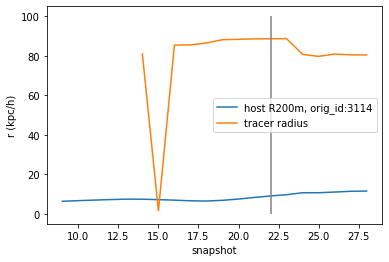

In [14]:
#
HOI = 69
TOI = 18
hostr = sdata['halos']['R200m'][HOI]
tcrr = sdata['tcr_sho']['res_tjy']['r'][TOI]
snaps = np.arange(tcrr.shape[0])
alive = tcrr > 0
plt.plot(snaps[hostr > 0], hostr[hostr > 0], label = 'host R200m, orig_id:%d'%(sdata['halos']['id'][HOI, sdata['halos']['first_snap'][HOI]]))
plt.plot(snaps[tcrr > 0], tcrr[tcrr > 0], label = 'tracer radius')
plt.vlines([22], 0, 100, color = 'gray')
plt.legend()
plt.xlabel('snapshot')
plt.ylabel('r (kpc/h)')

In [25]:
trackers = vines.createHaloTracks(16)
host = vines.createHostSphere(16)

img = Image(trackers + [host])
fig = img.getFig()
fig.show()

From Logfile:

[   1] *** Halo     4140, Tracer 6704 (desc_id -1, status 3): Created, first snap 22, instruction 1, r = 13.51 = 0.95 R200m.
[   1] *** Halo        ?, Tracer 6704 (desc_id 22970, status 3): Trajectory at snap  20: halo x [32.674 55.543 35.358], tcr x [32.653 55.638 35.262], r 17.54, vr -67.71, R 13.17, r/R 1.33, entered 2.
[   1] *** Halo        ?, Tracer 6704 (desc_id 22970, status 3): Trajectory at snap  21: halo x [32.698 55.559 35.359], tcr x [32.658 55.623 35.272], r 15.04, vr -47.10, R 13.72, r/R 1.10, entered 2.
[   1] *** Halo        ?, Tracer 6704 (desc_id 22970, status 3): Trajectory at snap  22: halo x [32.713 55.554 35.362], tcr x [32.676 55.609 35.284], r 13.51, vr -61.00, R 14.26, r/R 0.95, entered 2.

[   1] *** Halo        ?, Tracer 6704 (desc_id 25510, status 3): Trajectory at snap  23: halo x [32.691 55.591 35.290], tcr x [32.960 55.400 35.539], r 55.19, vr -133.50, R 10.85, r/R 5.09, entered 2.

This feels like a bug on SPARTA's behalf, not sure what status 3 means or where the descendent id comes from. Or necessarily why there's a question mark in the halo id column

1) eliminate the resolution limits in sparta (generate new moria trees)
2) use sparta data to follow sub/host relations (not tracers) - look at host switch
3) determine if they are phantoms
4) plot of host mass
5) major merger events
6) Bakels 2022 - backsplash halos paper, energy + ang mom cuts
7) look at Phil's paper

ValueError: no field of name descendant_index